In [8]:
# Import necessary libraries
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPTokenizer, CLIPModel
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn



# Initialize CLIP processor and tokenizer
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')


In [9]:
import torch

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Current device:', device)

Current device: cuda


In [11]:
class CaptionDataset(Dataset):
    def __init__(self, dataset, clip_model_name="openai/clip-vit-base-patch32", device=device):
        self.image = dataset['image']
        self.caption_list = dataset['caption']
        
        self.device = device

        self.processor = CLIPProcessor.from_pretrained(clip_model_name)
        self.tokenizer = CLIPTokenizer.from_pretrained(clip_model_name)
        self.clip_model = CLIPModel.from_pretrained(clip_model_name).eval().to(self.device)

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        image = self.image[idx]
        caption_list = self.caption_list[idx]
        
        # ---- Encode image with CLIP ----
        img_tensor = self.processor(images=image, return_tensors="pt").to(self.device)
        #print('IMG TENSOR SHAPE', img_tensor.shape) # channels, height, width
        
        # ---- Tokenize input caption ----
        caption = caption_list[0] # get the first caption in the list
        #print('caption len:', len(caption))
        tokens = self.tokenizer(caption, padding="max_length", max_length=32, return_tensors="pt", truncation=True)

        input_ids_full = tokens["input_ids"].to(self.device)  # [1, seq_len]
        #print('text_input_ids_full shape:', input_ids_full.shape)
        mask = tokens["attention_mask"].to(self.device) # get the mask out

        with torch.no_grad():
            # Use only embedding layer from CLIP
            text_embeddings = self.clip_model.text_model.embeddings(input_ids_full).squeeze(0).to(self.device)

            # Get the CLIP encoded image embeddings
            patch_embeddings = self.clip_model.vision_model(**img_tensor).last_hidden_state[:, 1:, :].squeeze(0).to(self.device) # shape: [1, num_patches, hidden_dim]
            #print('Patch embeddings shape:', patch_embeddings.shape)           
            
            
        target_ids = input_ids_full.squeeze(0).to(self.device)

        #print('IMG EMBEDDINGS SHAPE', patch_embeddings.shape)
        #print('TEXT EMBEDDINGS SHAPE', text_embeddings.shape)
        #print('TARGET IDS SHAPE', target_ids.shape)
        #print('MASK SHAPE', mask.shape)

        return patch_embeddings, text_embeddings, target_ids, mask
            


# create the image captioning model

⬆️ The code above projects the text and image embeddings into the same shape so now we can send it! 

In [12]:
# Create Masked Self Attention Head
class MaskedAttentionHead(nn.Module):
    def __init__(self, embedding_dim, head_dim):
        super(MaskedAttentionHead, self).__init__()
        self.head_dim = head_dim

        # Linear projections for query, key, value
        self.weight_q = nn.Linear(embedding_dim, head_dim)
        self.weight_k = nn.Linear(embedding_dim, head_dim)
        self.weight_v = nn.Linear(embedding_dim, head_dim)

        self.linear_projection = nn.Linear(head_dim, embedding_dim)

    def forward(self, decoder_sequence):
        # embedded decoder sequence shape: [batch_size, seq_length, embedding_dim]

        # Project to head dimension
        Q = self.weight_q(decoder_sequence)
        K = self.weight_k(decoder_sequence)
        V = self.weight_v(decoder_sequence)

        # Make the mask
        seq_len = decoder_sequence.shape[1]
        mask = torch.triu(torch.ones(seq_len, seq_len, device=decoder_sequence.device), diagonal=1)
        mask = mask.masked_fill(mask==1, float('-inf'))

        # Calculate attention scores (scaled dot product)
        A = torch.einsum('bid,bjd->bij', Q, K)
        A = A / (self.head_dim ** 0.5) 

        A = A + mask
        # Apply softmax
        A = torch.softmax(A, dim=-1)

    
        #  Apply attention weights to values
        H = torch.einsum('bij,bjd->bid', A, V)
        
        # Add projection layer for output to return back to the original embedding dimension
        #output = self.linear_projection(H)

        return H

In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads

     
        self.heads = nn.ModuleList(
            [MaskedAttentionHead(embedding_dim, self.head_dim) for _ in range(num_heads)]
            )
        
        # The output of the CrossAttention Head and MaskedAttentionHead still needs to be projected
        # Back to the embedding dimensions of the head_dim x vocab_size
        
        self.output_projection = nn.Linear(num_heads * self.head_dim, embedding_dim)

        

    def forward(self, decoder_sequence):
        # decoder_sequence: [batch_size, seq_length, embedding_dim]
        # encoder_output: [batch_size, num_patches, embedding_dim] (only used in cross-attention)
        # mask: [batch_size, seq_length, seq_length] (only used in self-attention)

        # Process each head
        head_outputs = []
        for head in self.heads:
                # For masked self-attention, we only need decoder sequence and mask
                head_output = head(decoder_sequence)
                #print("\nmasked attention head output shape: ", head_output.shape)
                
                head_outputs.append(head_output)

        # Concatenate head outputs
        concat_heads = torch.cat(head_outputs, dim=-1)
        
        # Project back to embedding dimension
        output = self.output_projection(concat_heads)
        #print("Multihead attention output shape: ", output.shape)
        
        return output



In [14]:
class DecoderBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, mlp_dimension):
        super(DecoderBlock, self).__init__()
        
        # First layer norm
        self.ln1 = nn.LayerNorm(embedding_dim)
        
        # Masked multi-head attention for decoder sequence self-attention
        self.masked_mha = MultiHeadAttention(embedding_dim, num_heads)
        
        
        # Third layer norm
        self.ln2 = nn.LayerNorm(embedding_dim)
        
        # Feed forward network
        self.ffn = nn.Sequential(
            nn.Linear(embedding_dim, mlp_dimension),
            nn.ReLU(),
            nn.Linear(mlp_dimension, embedding_dim)
        )

    def forward(self, decoder_sequence):
        # decoder_sequence: the input sequence to decode (e.g., [START, 1, 2, 3])
        # encoder_output: the encoded image from the encoder
        # mask: causal mask to prevent attending to future tokens

        # First masked self-attention block with residual connection
        # This allows decoder sequence to attend to its own past tokens
        # First masked self-attention
        residual = decoder_sequence
        decoder_sequence = self.ln1(decoder_sequence)
        decoder_sequence = self.masked_mha(decoder_sequence)
        decoder_sequence = residual + decoder_sequence

        
        # # FFN block with residual connection
        residual = decoder_sequence
        decoder_sequence = self.ln2(decoder_sequence)
        decoder_sequence = self.ffn(decoder_sequence)
        decoder_sequence = residual + decoder_sequence
        
        return decoder_sequence



In [15]:
class Decoder(nn.Module):
    def __init__(self, embedding_dim, num_heads, mlp_dimension, num_layers, vocab_size):
        super(Decoder, self).__init__()
        
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
    
        # Create positional embeddings for decoder sequence ONCE during initialization
        #self.positional_embeddings = nn.Parameter(
        #    torch.randn(1, input_sequence_length, embedding_dim),
        #    requires_grad=True
        #)
        
        # Create decoder blocks
        self.decoder_blocks = nn.ModuleList([
            DecoderBlock(embedding_dim, num_heads, mlp_dimension)
            for _ in range(num_layers)
        ])
        
        # Final layer norm
        self.final_ln = nn.LayerNorm(embedding_dim)

        # Output projection to vocabulary size
        # This converts decoder features to logits over possible next tokens
        self.output_projection = nn.Linear(embedding_dim, vocab_size)

    def forward(self, concatenated_embeddings, return_logits=True):
        # return_logits: whether to return prediction logits or just decoder features
        # by default, we return logits

        # Add positional embeddings to decoder sequence
        #decoder_sequence = embedded_decoder_sequence + self.positional_embeddings
        
        # Pass through decoder blocks
        for block in self.decoder_blocks:
            concatenated_embeddings = block(concatenated_embeddings)
        
        # Apply final layer norm
        decoder_features = self.final_ln(concatenated_embeddings)
        
        if return_logits:
            # Convert features to logits for prediction
            # Shape: [batch_size, seq_length, vocab_size]
            logits = self.output_projection(decoder_features)
            return logits
        else:
            # Return decoder features if needed
            return decoder_features

### MODEL

In [19]:
# load dataset and create train and test sets
raw_dataset = load_dataset("nlphuji/flickr30k", split='test[:5000]')

# Split the dataset into training and testing sets
train_test_split = raw_dataset.train_test_split(test_size=0.3)
train = train_test_split['train']
test = train_test_split['test']

print(test)
print(train)

test_caption = CaptionDataset(test)
train_caption = CaptionDataset(train)

# Create a DataLoader
test_dataloader = DataLoader(test_caption, batch_size=50, shuffle=False)  # Adjust batch_size as needed
train_dataloader = DataLoader(train_caption, batch_size=50, shuffle=False)


Dataset({
    features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
    num_rows: 1500
})
Dataset({
    features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
    num_rows: 3500
})


In [20]:
import torch.optim as optim
from tqdm import tqdm

# Parameters for decoder
embedding_dim = 512
num_heads = 8
mlp_dimension = 2048
num_layers = 2
input_sequence_length = 32
vocab_size = 49408

decoder = Decoder(embedding_dim, num_heads, mlp_dimension, num_layers, vocab_size).to(device)
#decoder = SimpleCaptionDecoder(embedding_dim, num_heads, mlp_dimension, num_layers, vocab_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(decoder.parameters(), lr=1e-4)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):

    decoder.train()

    # Training phase
    train_pbar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', mininterval=0.1)

    epoch_losses = [] # store all individual losses and calculate the true average at the end

    # Iterate over the DataLoader and print the outputs
    for batch_idx, (patch_embeddings, text_embeddings, target_ids, mask) in enumerate(train_pbar):
        
        # Move projection layer to device
        image_input_dim = patch_embeddings.shape[2]# get dimension from patch embeddings
        image_projection_layer = nn.Linear(image_input_dim, embedding_dim).to(device)
        img_features = image_projection_layer(patch_embeddings)
        #print('\nProjected img shape:', img_features.shape)
        #print('Projected text shape:', text_embeddings.shape)

        # Concatenate image features and text embeddings
        decoder_inputs = torch.cat([img_features, text_embeddings], dim=1).to(device)
        targets = target_ids.to(device)

        # Forward pass through the decoder
        logits = decoder(decoder_inputs)

        # Compute loss
        # Shift logits and targets to align for cross-entropy
        #logits = logits[:, :-1].contiguous().view(-1, logits.size(-1))
        #targets = target_ids[:, 1:].contiguous().view(-1)
        #loss = criterion(logits, targets)

        # Calculate loss only on text portion
        text_logits = logits[:, -32:, :] # Shape: [batch_size, 32, vocab_size]
        text_targets = target_ids[:, -32:]  # Shape: [batch_size, 32]
        text_mask = mask[:, -32:] # Shape: [batch_size, 32]

        # Reshape for loss calculation
        text_logits = text_logits.reshape(-1, text_logits.size(-1))
        text_targets = text_targets.reshape(-1)
        text_mask = text_mask.reshape(-1)

        # Calculate loss only on masked positions
        loss = criterion(
            text_logits[text_mask.bool()],
            text_targets[text_mask.bool()]
        )

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # Store the loss for this batch
        epoch_losses.append(loss.item())
        
        # Update progress bar with current batch loss
        train_pbar.set_postfix({
            'batch_loss': f'{loss.item():.4f}'
        })
        train_pbar.update(1)

    # Close progress bar for this epoch
    train_pbar.close()
    
    # Print epoch summary
    # Calculate and print training epoch average loss
    avg_train_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")
    print(" ")

     # Validation phase
    decoder.eval()  # Set model to evaluation mode
    val_losses = []  # Store all validation losses
    
    with torch.no_grad():  # Disable gradient calculation for validation
        val_pbar = tqdm(test_dataloader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]', mininterval=0.1)
        
        for batch_idx, (patch_embeddings, text_embeddings, target_ids, mask) in enumerate(val_pbar):
            # Move projection layer to device
            image_input_dim = patch_embeddings.shape[2]
            image_projection_layer = nn.Linear(image_input_dim, embedding_dim).to(device)
            img_features = image_projection_layer(patch_embeddings)

            # Concatenate image features and text embeddings
            decoder_inputs = torch.cat([img_features, text_embeddings], dim=1).to(device)
            targets = target_ids.to(device)

            # Forward pass through the decoder
            logits = decoder(decoder_inputs)

            # Calculate loss only on text portion
            text_logits = logits[:, -32:, :]
            text_targets = target_ids[:, -32:]
            text_mask = mask[:, -32:]

            # Reshape for loss calculation
            text_logits = text_logits.reshape(-1, text_logits.size(-1))
            text_targets = text_targets.reshape(-1)
            text_mask = text_mask.reshape(-1)

            # Calculate loss only on masked positions
            val_loss = criterion(
                text_logits[text_mask.bool()],
                text_targets[text_mask.bool()]
            )
            
            # Store validation loss
            val_losses.append(val_loss.item())
            
            # Update progress bar with current validation loss
            val_pbar.set_postfix({
                'val_loss': f'{val_loss.item():.4f}'
            })
            val_pbar.update(1)
    
    # Close validation progress bar
    val_pbar.close()
    
    # Calculate average validation loss
    avg_val_loss = sum(val_losses) / len(val_losses)
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} Val Loss: {avg_val_loss:.4f}")

        
print("Training complete.")



Epoch 1/5 [Train]: 100%|██████████| 70/70 [00:42<00:00,  1.64it/s, batch_loss=5.4321]


Epoch 1/5, Train Loss: 7.5467
 


Epoch 1/5 [Val]: 100%|██████████| 30/30 [00:15<00:00,  1.94it/s, val_loss=5.6531]


Epoch 1/5 Val Loss: 5.4848


Epoch 2/5 [Train]: 100%|██████████| 70/70 [00:43<00:00,  1.61it/s, batch_loss=3.8824]


Epoch 2/5, Train Loss: 4.6026
 


Epoch 2/5 [Val]: 100%|██████████| 30/30 [00:15<00:00,  1.98it/s, val_loss=4.2237]


Epoch 2/5 Val Loss: 4.0071


Epoch 3/5 [Train]: 100%|██████████| 70/70 [00:41<00:00,  1.68it/s, batch_loss=2.9855]


Epoch 3/5, Train Loss: 3.5239
 


Epoch 3/5 [Val]: 100%|██████████| 30/30 [00:14<00:00,  2.00it/s, val_loss=3.3860]


Epoch 3/5 Val Loss: 3.1297


Epoch 4/5 [Train]: 100%|██████████| 70/70 [00:42<00:00,  1.64it/s, batch_loss=2.3364]


Epoch 4/5, Train Loss: 2.7366
 


Epoch 4/5 [Val]: 100%|██████████| 30/30 [00:15<00:00,  2.00it/s, val_loss=2.8021]


Epoch 4/5 Val Loss: 2.4917


Epoch 5/5 [Train]: 100%|██████████| 70/70 [00:41<00:00,  1.68it/s, batch_loss=1.9062]


Epoch 5/5, Train Loss: 2.2030
 


Epoch 5/5 [Val]: 100%|██████████| 30/30 [00:15<00:00,  1.99it/s, val_loss=2.3559]

Epoch 5/5 Val Loss: 2.0748
Training complete.


In [21]:
# Save the model using torch load
model_save_path = "decoder_08051225.pt"
torch.save(decoder, model_save_path)

print(f"Model saved to {model_save_path}")




Model saved to decoder_08051225.pt


### RUN INFERENCE

In [29]:

import matplotlib.pyplot as plt


def generate_caption(image, decoder, clip_model, clip_processor, tokenizer, device, max_length=32):
    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    # Process image with CLIP
    img_tensor = clip_processor(images=image, return_tensors="pt").to(device)
    
    # Get image embeddings
    with torch.no_grad():
        # Get image features from CLIP
        patch_embeddings = clip_model.vision_model(**img_tensor).last_hidden_state[:, 1:, :].squeeze(0)
        
        # Project image to same dimension as text (512)
        image_projection = nn.Linear(patch_embeddings.shape[-1], 512).to(device)
        img_features = image_projection(patch_embeddings)
        
        # Initialize with start token
        start_token = torch.tensor([[49406]]).to(device)  # [START] token
        text_embeddings = clip_model.text_model.embeddings(start_token)
        
        # Initialize caption generation
        current_tokens = [49406]  # Start token
        print("Generating caption: ", end="", flush=True)
        
        # Generate tokens one by one
        for _ in range(max_length):
            # Concatenate image and text embeddings along sequence dimension
            decoder_inputs = torch.cat([img_features.unsqueeze(0), text_embeddings], dim=1)
            
            # Get logits from decoder
            logits = decoder(decoder_inputs)
            
            # Get next token (only look at the last position)
            next_token = logits[0, -1].argmax(dim=-1).item()
            
            # Break if we predict the end token
            if next_token == 49407:  # End token
                break
                
            # Add token to sequence
            current_tokens.append(next_token)
            
            # Update text embeddings for next iteration
            text_embeddings = clip_model.text_model.embeddings(torch.tensor([current_tokens]).to(device))
            
            # Print the new word
            new_word = tokenizer.decode([next_token])
            print(new_word, end=" ", flush=True)
        
        print()  # New line at end
        return tokenizer.decode(current_tokens)



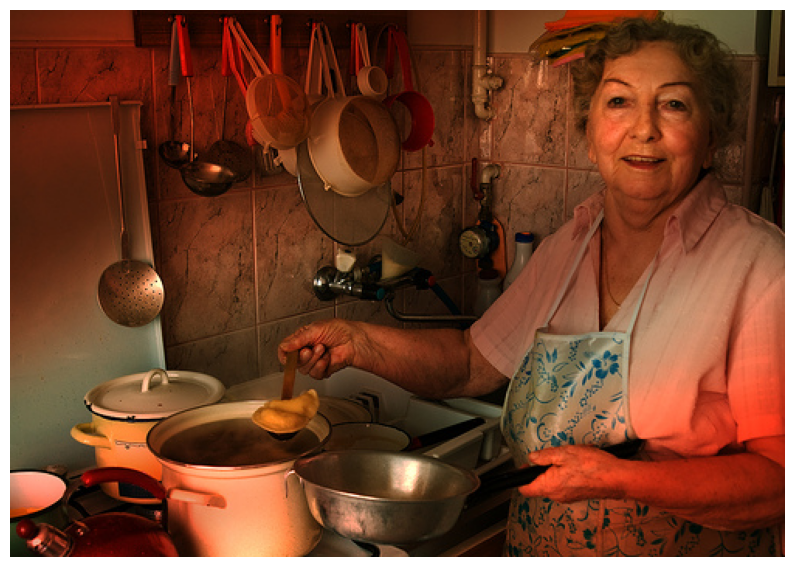

Generating caption: <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> <|startoftext|> 


In [30]:
import random

# Example usage:
# Load models and processors
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")


# Initialize decoder
embedding_dim = 512
num_heads = 8
mlp_dimension = 2048
num_layers = 2
vocab_size = 49408

decoder = Decoder(embedding_dim, num_heads, mlp_dimension, num_layers, vocab_size).to(device)

# Load trained weights if provided
decoder = torch.load('decoder_08051225.pt', weights_only=False)
decoder.eval()
decoder = decoder.to(device)

# Get a random image from the test set
idx = random.randint(0, len(test) - 1)
sample = test[idx]
image = sample['image']
true_caption = sample['caption'][0]  # Get the first caption

# Generate caption with visualization
generate_caption = generate_caption(image, decoder, clip_model, clip_processor, tokenizer, device)

### DUMP

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os
from datetime import datetime
import wandb
import time


def train_transformer(
    model,
    train_loader,
    val_loader,
    num_epochs,
    learning_rate,
    device='cuda' if torch.cuda.is_available() else 'cpu'
):
    
    # Initialize wandb
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    run_name = f"full-transformer-{timestamp}"
    wandb.init(project="full-transformer-mnist",
               name=run_name,
               group="experiment-1",
               config={
                   "learning_rate": learning_rate,
                   "num_epochs": num_epochs,
                   "batch_size": train_loader.batch_size,
                   "embedding_dim": model.embedding_dim,
                   "num_heads": model.num_heads,
                   "mlp_dimension": model.mlp_dimension,
                   "num_layers": model.num_layers,
                   "max_seq_length": model.num_patches,
                   "vocab_size": model.vocab_size
               })
    
    # Move model to device
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # TRAINING LOOP 
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        # Training phase
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', mininterval=1.0) # udpate every 1 second
        for batch_idx, (input_images, decoder_inputs, targets) in enumerate(train_loader):
            # Move to device
            input_images = input_images.to(device)
            decoder_inputs = decoder_inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(input_images, decoder_inputs)

            # Calculate loss
            # outputs.view(-1, outputs.size(-1)) is to flatten the output to a 1D tensor
            # targets.view(-1) is to flatten the targets to a 1D tensor
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update metrics
            total_loss += loss.item()
            _, predicted = outputs.max(-1)
            total_correct += (predicted == targets).sum().item()
            total_samples += targets.numel()
            
            # Calculate current accuracy
            current_acc = (total_correct / total_samples * 100)
            
            
            # Update progress bar
            train_pbar.set_postfix({
                'loss': total_loss / (batch_idx + 1),
                'acc': f'{current_acc:.2f}%'
            })

            train_pbar.update(1)
        
        train_pbar.close()

        
        # Calculate training metrics after all batches
        train_loss = total_loss / len(train_loader)
        train_acc = (total_correct / total_samples * 100)
        print(f"\nTraining completed for epoch {epoch+1}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

        # After training phase
        wandb.log({
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "epoch": epoch + 1
        })
            
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_samples = 0
        
        # No need to compute gradients for validation
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]', mininterval=1.0)
            for batch_idx, (images, decoder_input, targets) in enumerate(val_pbar):
                # Move to device
                images = images.to(device)
                decoder_input = decoder_input.to(device)
                targets = targets.to(device)
                
                # Forward pass
                outputs = model(images, decoder_input)
                
                # Calculate loss
                loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
                val_loss += loss.item()

                # Update validation metrics
                _, predicted = outputs.max(-1)
                val_correct += (predicted == targets).sum().item()
                val_samples += targets.numel()

                # Calculate current validation accuracy
                current_val_acc = (val_correct / val_samples * 100)
                

                # Update progress bar
                val_pbar.set_postfix({
                    'loss': val_loss / (batch_idx + 1),
                    'acc': f'{current_val_acc:.2f}%'
                })

                val_pbar.update(1)

        val_pbar.close()
                
        # Calculate validation metrics
        val_loss = val_loss / len(val_loader)
        val_acc = (val_correct / val_samples * 100)

        # After validation phase
        wandb.log({
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "epoch": epoch + 1
        })
        

      # Print epoch summary
        print(f'\nEpoch {epoch+1}/{num_epochs} Summary:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # After training loop completes
    # 1. Save model weights
    model_save_path = f"transformer_weights_{timestamp}_mnistscattered.pt"

    torch.save(model, model_save_path)

    print(f"\nModel weights saved to {model_save_path}")

    # Finish wandb run
    wandb.finish()
            
        
    

In [ ]:
# captions produces a list of captions
#captions = [caption for caption_list[0] for caption_list in test['caption']]  

captions = []
for caption_list in test['caption']:
    for caption in caption_list[0]:
        captions.append(caption)



The change from total_loss and num_batches to epoch_losses = [] offers several advantages:
More Accurate Average:
With total_loss and num_batches, you're calculating a running average that might be affected by the order of batches
With epoch_losses, you store all individual losses and calculate the true average at the end, which is more accurate
More Information:
By storing all losses in a list, you can:
Calculate the median loss
Find the minimum and maximum losses
Plot the loss distribution
Detect outliers or unusual patterns
Calculate standard deviation
Debugging and Analysis:
If you notice something unusual in the average loss, you can look at the individual losses to understand what's happening
You can track how the loss changes throughout the epoch